In [3]:
# check if pyspark works
import pyspark
print(pyspark.__version__)

3.5.1


In [4]:
from pyspark.sql import SparkSession

# Start spark session
spark = SparkSession.builder \
    .appName("Multiclass classification IoT") \
    .getOrCreate()

# Load datasets
def load_test_data(debug=False):
    if debug:
        test_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-test.csv", header=True, inferSchema=True).limit(200)
        train_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-train.csv", header=True, inferSchema=True).limit(20000)
    else:
        test_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-test.csv", header=True, inferSchema=True)
        train_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-train.csv", header=True, inferSchema=True)
        
    return test_data, train_data

test_data, train_data = load_test_data(debug=True)


In [5]:
# Display the first few rows of the training dataset to verify it's loaded correctly
train_data.show(5)
print(train_data.count())

# Display the first few rows of the testing dataset to verify it's loaded correctly
test_data.show(5)
print(test_data.count())

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+--------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MI

In [6]:
# Print the schema of the loaded data to confirm the data types of each column
train_data.printSchema()
test_data.printSchema()

root
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- CLIENT_TCP_FLAGS: integer (nullable = true)
 |-- SERVER_TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- DURATION_IN: integer (nullable = true)
 |-- DURATION_OUT: integer (nullable = true)
 |-- MIN_TTL: integer (nullable = true)
 |-- MAX_TTL: integer (nullable = true)
 |-- LONGEST_FLOW_PKT: integer (nullable = true)
 |-- SHORTEST_FLOW_PKT: integer (nullable = true)
 |-- MIN_IP_PKT_LEN: integer (nullable = true)
 |-- MAX_IP_PKT_LEN: integer (nullable = true)
 |-- SRC_TO

### Data Preprocessing and Exploratory Data Analysis (EDA)

In [7]:
# Identifying missing values
from pyspark.sql.functions import col, count, when, isnan

# Count nulls and NaNs in each column
def count_missing(data):
    #data.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in data.columns]).show()
    data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

count_missing(train_data)

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MIN_

In [8]:
# Identifying missing values
count_missing(test_data)

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MIN_

The dataset is clean and doesn't have any missing values, so there's no need for further cleaning.

#### Encoding
On the dataset, which consists of network traffic data, several categorical variables could potentially benefit from encoding. The decision to apply encoding techniques depends on whether the variables are nominal (without an inherent order) or ordinal (with a specific order) and whether they are used as features in the model. 

After an understanding of data and the variables meaning, we considered some variables for encoding:
- **IPV4_SRC_ADDR and IPV4_DST_ADDR** (Categorical nominal): These are IP addresses and typically should be treated as categorical.
- **Attack** (categorical Nominal): In machine learning projects involving classification tasks, the target variable (also known as the label or response variable) is crucial as it's the outcome the model is trying to predict. On the project, the target variable consists of categorical data (e.g., text labels representing different classes), it needs to be converted into a numeric format. This conversion is essential because most machine learning algorithms require numeric input to perform calculations during model training.


In [9]:
from pyspark.sql.functions import countDistinct

# Count distinct values in IPV4_SRC_ADDR
distinct_src_subnet_count = train_data.select(countDistinct("IPV4_SRC_ADDR").alias("Distinct_SRC_Count"))

# Count distinct values in IPV4_DST_ADDR
distinct_dst_subnet_count = train_data.select(countDistinct("IPV4_DST_ADDR").alias("Distinct_DST_Subnet"))

# Show the results
distinct_src_subnet_count.show(truncate=False)
distinct_dst_subnet_count.show(truncate=False)

+------------------+
|Distinct_SRC_Count|
+------------------+
|60                |
+------------------+

+-------------------+
|Distinct_DST_Subnet|
+-------------------+
|355                |
+-------------------+



Given the high number of distinct values in the IPV4_ADDR column, subnet segmentation was performed to facilitate more effective encoding. This approach reduces the granularity of the data, thereby simplifying the feature space without significantly compromising the informational value of the IP addresses. Segmentation enables us to manage the high cardinality of the IP addresses, which is critical for applying machine learning techniques efficiently and effectively. By categorizing the IP addresses into their respective subnets, we can capture essential network-level behaviors while avoiding the computational complexity associated with the vast number of unique full IP addresses.

In [10]:
from pyspark.sql.functions import concat_ws, split

def add_subnet_columns(data):
    # Add a new column for the subnet (first two octets) for source and destination IP addresses
    data = data.withColumn(
        "IPV4_SRC_ADDR_Subnet",
        concat_ws(".", split(col("IPV4_SRC_ADDR"), "\\.")[0], split(col("IPV4_SRC_ADDR"), "\\.")[1])
    )

    data = data.withColumn(
        "IPV4_DST_ADDR_Subnet",
        concat_ws(".", split(col("IPV4_DST_ADDR"), "\\.")[0], split(col("IPV4_DST_ADDR"), "\\.")[1])
    )

    return data

train_data = add_subnet_columns(train_data)
test_data = add_subnet_columns(test_data)

# Show the new columns along with the original IP addresses
train_data.select("IPV4_SRC_ADDR", "IPV4_SRC_ADDR_Subnet", "IPV4_DST_ADDR", "IPV4_DST_ADDR_Subnet").show(truncate=False)


+-------------+--------------------+--------------+--------------------+
|IPV4_SRC_ADDR|IPV4_SRC_ADDR_Subnet|IPV4_DST_ADDR |IPV4_DST_ADDR_Subnet|
+-------------+--------------------+--------------+--------------------+
|192.168.1.32 |192.168             |192.168.1.180 |192.168             |
|192.168.1.30 |192.168             |192.168.1.194 |192.168             |
|192.168.1.31 |192.168             |192.168.1.190 |192.168             |
|192.168.1.32 |192.168             |192.168.1.195 |192.168             |
|192.168.1.38 |192.168             |192.168.1.194 |192.168             |
|192.168.1.31 |192.168             |192.168.1.193 |192.168             |
|192.168.1.32 |192.168             |192.168.1.195 |192.168             |
|192.168.1.32 |192.168             |192.168.1.190 |192.168             |
|192.168.1.35 |192.168             |192.168.1.1   |192.168             |
|192.168.1.30 |192.168             |192.168.1.195 |192.168             |
|192.168.1.35 |192.168             |192.168.1.1   |

In [11]:
from pyspark.sql.functions import countDistinct

# Count distinct values in IPV4_SRC_ADDR_Subnet
distinct_src_subnet_count = train_data.select(countDistinct("IPV4_SRC_ADDR_Subnet").alias("Distinct_SRC_Subnet_Count"))

# Count distinct values in IPV4_DST_ADDR_Subnet
distinct_dst_subnet_count = train_data.select(countDistinct("IPV4_DST_ADDR_Subnet").alias("Distinct_DST_Subnet_Count"))

# Show the results
distinct_src_subnet_count.show(truncate=False)
distinct_dst_subnet_count.show(truncate=False)

+-------------------------+
|Distinct_SRC_Subnet_Count|
+-------------------------+
|33                       |
+-------------------------+

+-------------------------+
|Distinct_DST_Subnet_Count|
+-------------------------+
|95                       |
+-------------------------+



- **Source IP Dimensionality:** The modest reduction in unique source subnets compared to the full source IP count suggests that the network traffic originates from a diverse set of locations or devices, with slightly clustered but still quite spread out origins. This might imply that any predictive modeling using source subnets as a feature would still need to handle a relatively high number of categories, potentially requiring further techniques to manage dimensionality or enhance interpretability.

- **Destination IP Dimensionality:** The more significant reduction in unique destination subnets points to a higher level of concentration of network traffic towards certain destination networks or servers. For modeling purposes, this could mean that destination subnet could be a more impactful feature, providing stronger predictive signals with fewer categories, thus improving model performance and simplicity.

Given the results, for destination subnets, straightforward categorical encoding methods like one-hot encoding might be feasible given the reduced number of unique values. For source subnets, considering the still high number of unique categories, methods like feature hashing or embedding might be more appropriate to prevent models from becoming too complex.

In [12]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, FeatureHasher
from pyspark.ml import Pipeline

# Define Indexers and Encoders for categorical variables
attack_indexer = StringIndexer(inputCol="Attack", outputCol="attack_index")

# Destination address
dst_subnet_indexer = StringIndexer(inputCol="IPV4_DST_ADDR_Subnet", outputCol="dst_subnet_index")

# Source address
# Feature hashing for source subnet since lower cardinality
# Just for graphing
src_subnet_indexer = StringIndexer(inputCol="IPV4_SRC_ADDR_Subnet", outputCol="src_subnet_index")


# Create a pipeline for encoding
encoding_pipeline = Pipeline(stages=[
    attack_indexer, 
    dst_subnet_indexer, 
    src_subnet_indexer,
])

# Fit the encoding pipeline to the training data
encoding_model = encoding_pipeline.fit(train_data)

# Transform both training and test data
encoded_train_data = encoding_model.transform(train_data)
encoded_test_data = encoding_model.transform(test_data)

# Show encoded features to verify
encoded_train_data.select("Attack", "attack_index", "IPV4_SRC_ADDR_Subnet", "IPV4_DST_ADDR_Subnet", "dst_subnet_index").show(truncate=False)

+---------+------------+--------------------+--------------------+----------------+
|Attack   |attack_index|IPV4_SRC_ADDR_Subnet|IPV4_DST_ADDR_Subnet|dst_subnet_index|
+---------+------------+--------------------+--------------------+----------------+
|scanning |1.0         |192.168             |192.168             |0.0             |
|scanning |1.0         |192.168             |192.168             |0.0             |
|Benign   |0.0         |192.168             |192.168             |0.0             |
|scanning |1.0         |192.168             |192.168             |0.0             |
|ddos     |3.0         |192.168             |192.168             |0.0             |
|Benign   |0.0         |192.168             |192.168             |0.0             |
|Benign   |0.0         |192.168             |192.168             |0.0             |
|password |4.0         |192.168             |192.168             |0.0             |
|xss      |2.0         |192.168             |192.168             |0.0       

In [13]:
# Drop the original columns that have been encoded and hashed
encoded_train_data = encoded_train_data.drop("Attack", "IPV4_SRC_ADDR_Subnet", "IPV4_DST_ADDR_Subnet", "IPV4_SRC_ADDR", "IPV4_DST_ADDR")

# Show the final columns in the training data
encoded_train_data.columns

['L4_SRC_PORT',
 'L4_DST_PORT',
 'PROTOCOL',
 'L7_PROTO',
 'IN_BYTES',
 'IN_PKTS',
 'OUT_BYTES',
 'OUT_PKTS',
 'TCP_FLAGS',
 'CLIENT_TCP_FLAGS',
 'SERVER_TCP_FLAGS',
 'FLOW_DURATION_MILLISECONDS',
 'DURATION_IN',
 'DURATION_OUT',
 'MIN_TTL',
 'MAX_TTL',
 'LONGEST_FLOW_PKT',
 'SHORTEST_FLOW_PKT',
 'MIN_IP_PKT_LEN',
 'MAX_IP_PKT_LEN',
 'SRC_TO_DST_SECOND_BYTES',
 'DST_TO_SRC_SECOND_BYTES',
 'RETRANSMITTED_IN_BYTES',
 'RETRANSMITTED_IN_PKTS',
 'RETRANSMITTED_OUT_BYTES',
 'RETRANSMITTED_OUT_PKTS',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'NUM_PKTS_UP_TO_128_BYTES',
 'NUM_PKTS_128_TO_256_BYTES',
 'NUM_PKTS_256_TO_512_BYTES',
 'NUM_PKTS_512_TO_1024_BYTES',
 'NUM_PKTS_1024_TO_1514_BYTES',
 'TCP_WIN_MAX_IN',
 'TCP_WIN_MAX_OUT',
 'ICMP_TYPE',
 'ICMP_IPV4_TYPE',
 'DNS_QUERY_ID',
 'DNS_QUERY_TYPE',
 'DNS_TTL_ANSWER',
 'FTP_COMMAND_RET_CODE',
 'Label',
 'attack_index',
 'dst_subnet_index',
 'src_subnet_index']

# EDA part
Converting dataset to pandas for graphics

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Row limit for converting to Pandas DataFrame for plotting (to avoid memory issues)
ROW_LIMIT = 20000

# Converte il DataFrame Spark in un DataFrame Pandas per l'analisi esplorativa
df_pd = encoded_train_data.limit(ROW_LIMIT).toPandas()


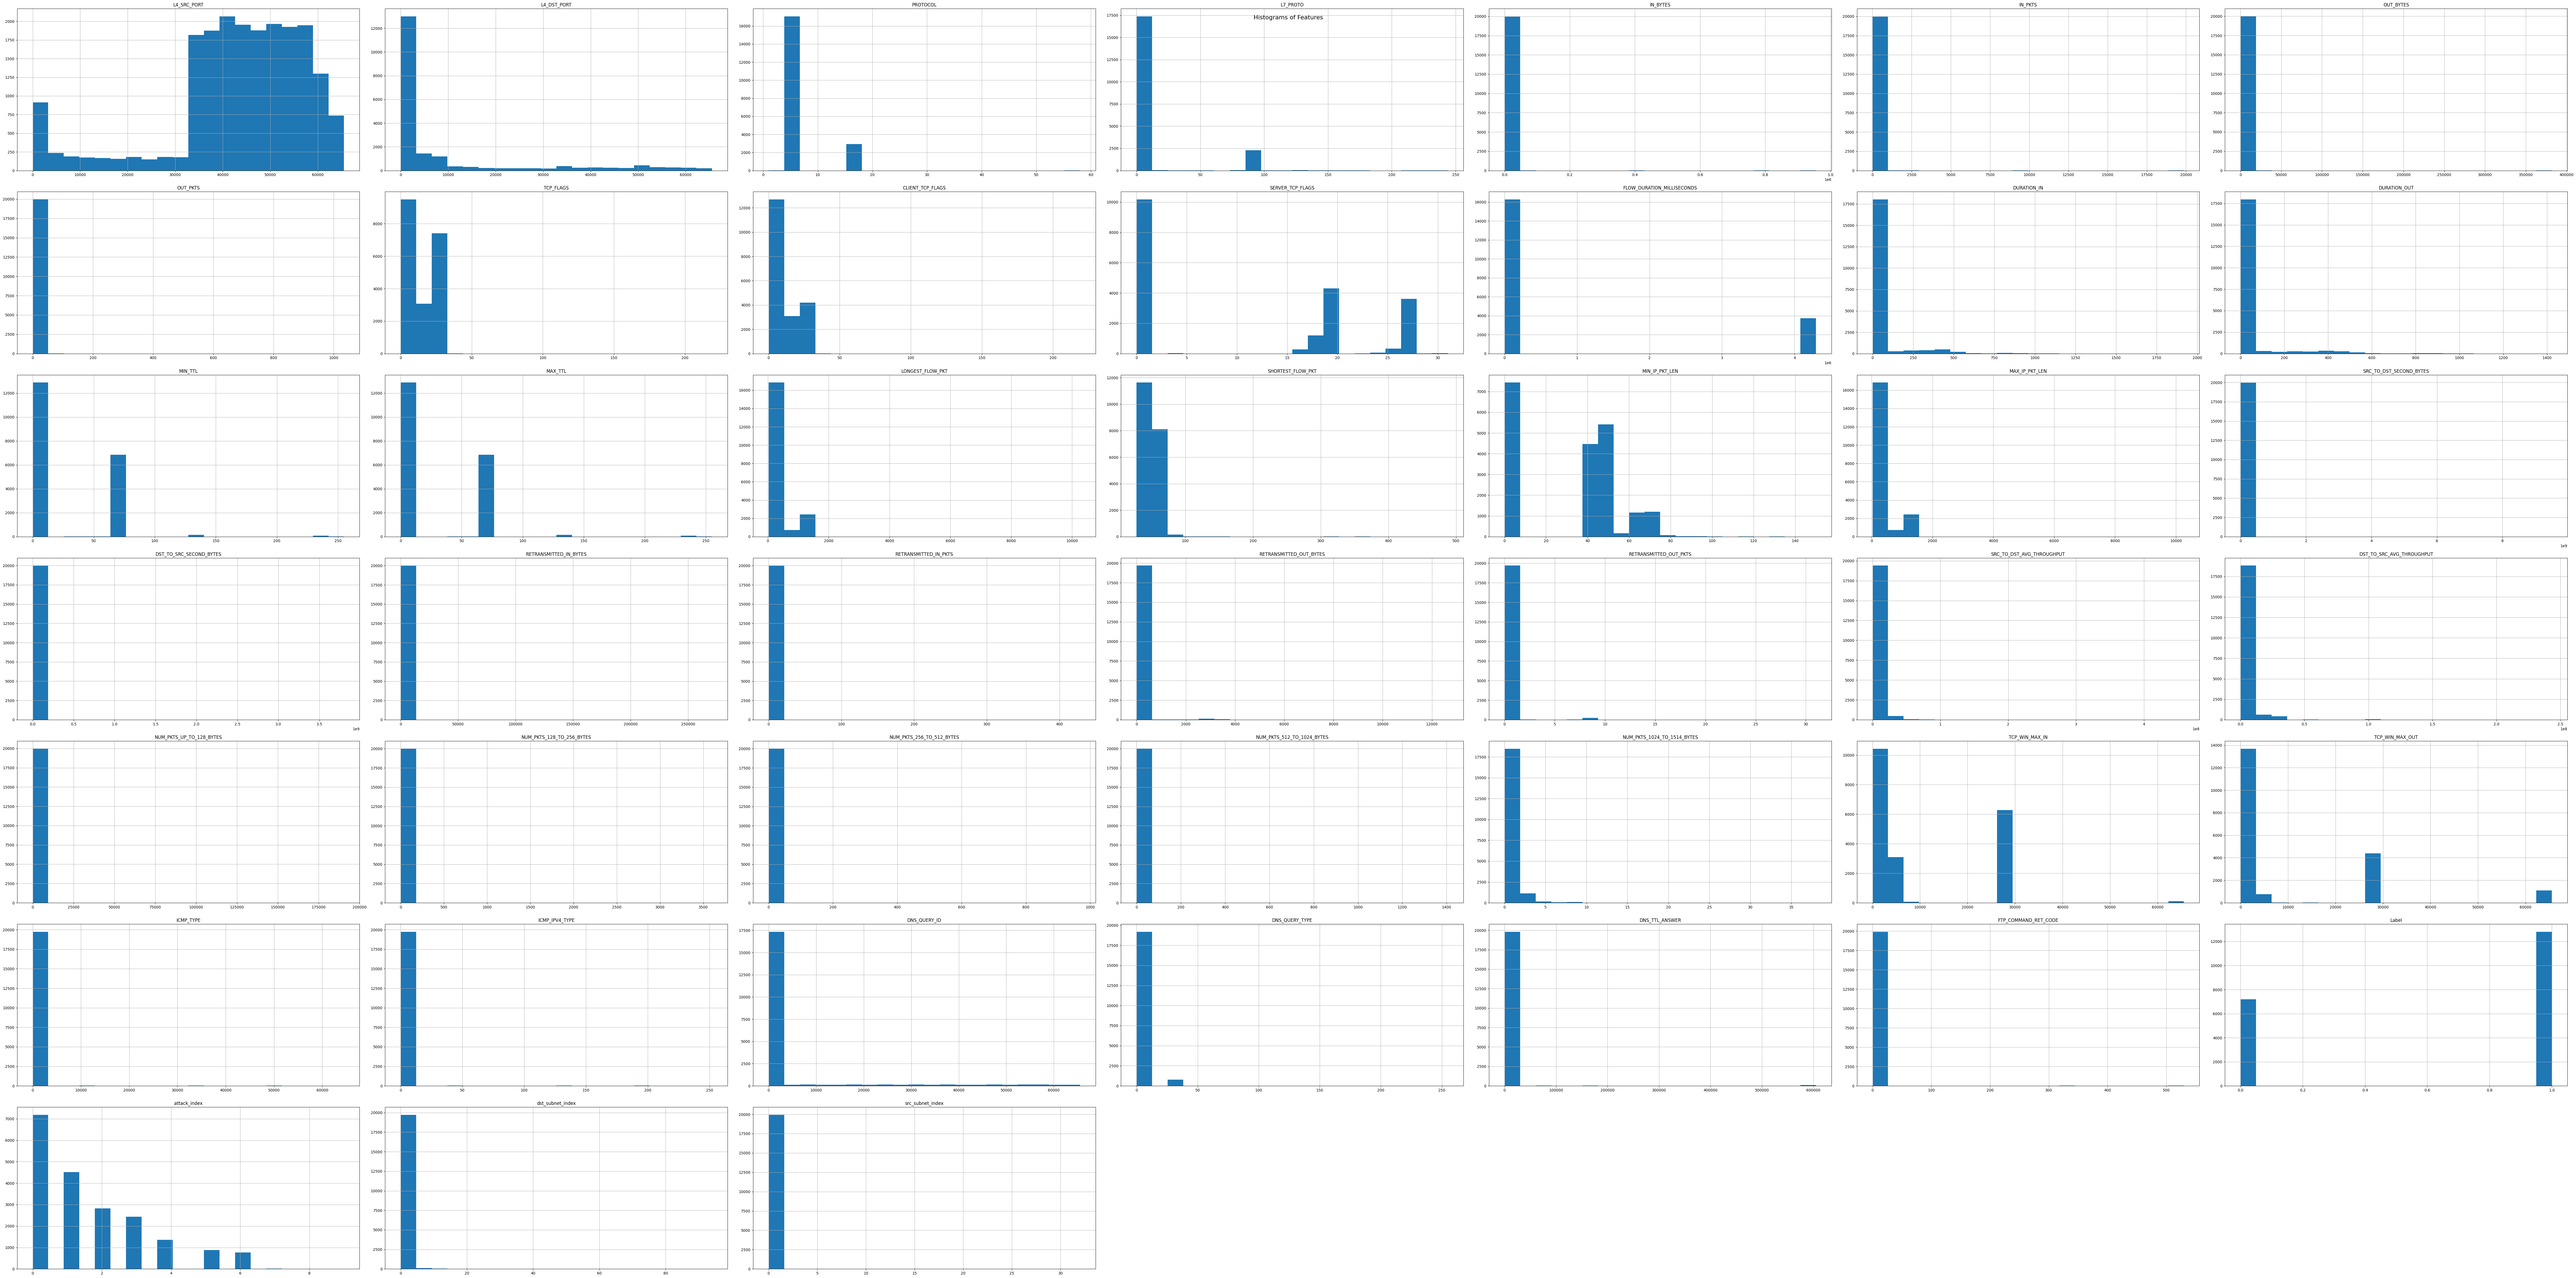

In [40]:
# Analisi esplorativa dei dati utilizzando Pandas e Seaborn
def features_hisogram(dataframe):
    # Istogrammi delle caratteristiche
    dataframe.hist(bins=20, figsize=(96, 48))
    plt.suptitle("Histograms of Features", fontsize=16)
    plt.tight_layout()
    plt.show()
    
features_hisogram(df_pd)

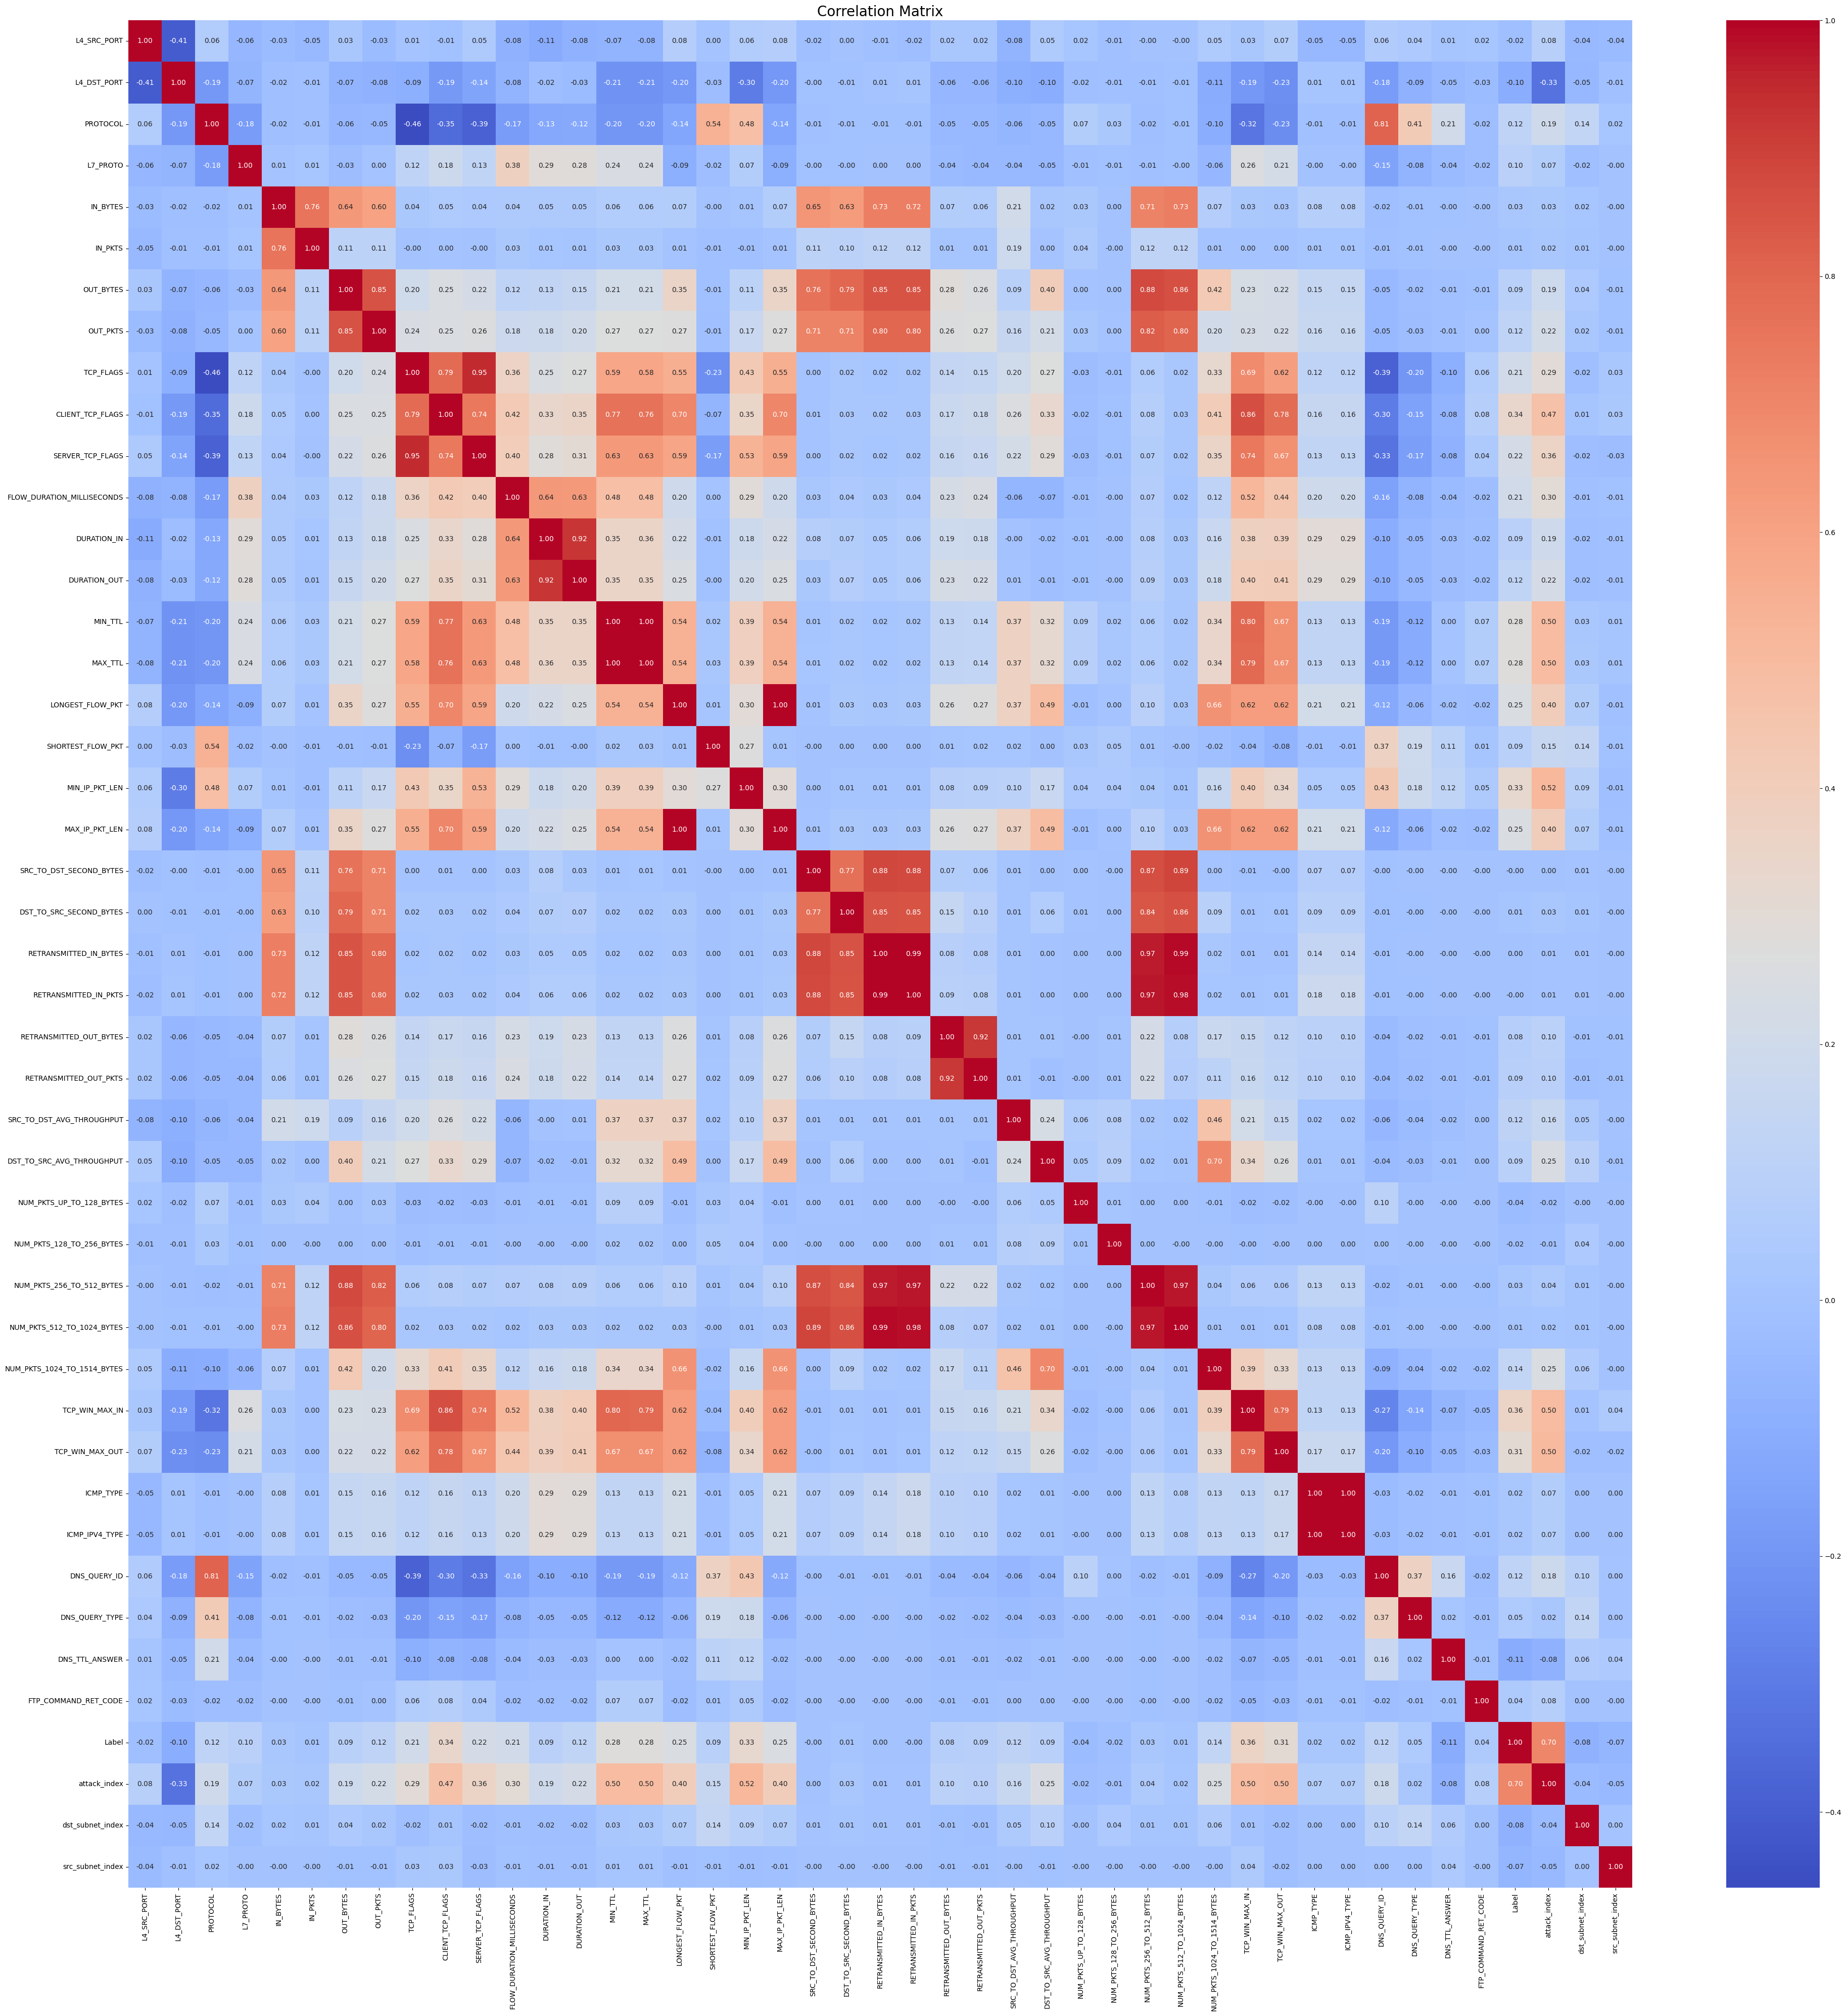

In [41]:
def heatmap(dataframe):
    # Matrice di correlazione
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(48, 48))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix', fontsize=20)
    plt.show()
    
heatmap(df_pd)

In [42]:
# Frequencias de categoria
# This function calculates the frequency of each category in a given column
# It use the full dataset to calculate the frequencies

from pyspark.sql.functions import count

def category_frequencies(data, column):
    # Calcular a frequência das categorias na variável 'Attack'
    frequency = data.groupBy(column).agg(count("*").alias("frequency")).orderBy("frequency", ascending=False)
    #attack_freq.show(truncate=False)
    return frequency

category_frequencies(encoded_train_data, "attack_index").show(truncate=False)



+------------+---------+
|attack_index|frequency|
+------------+---------+
|0.0         |7189     |
|1.0         |4516     |
|2.0         |2825     |
|3.0         |2430     |
|4.0         |1356     |
|5.0         |882      |
|6.0         |771      |
|7.0         |17       |
|8.0         |8        |
|9.0         |6        |
+------------+---------+



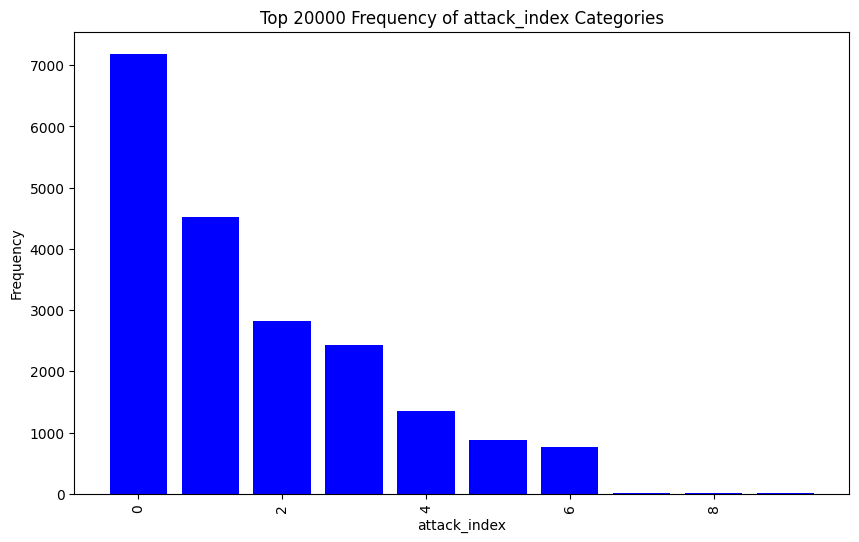

In [86]:
# Frequencias de categoria (plot)
import matplotlib.pyplot as plt
import pandas as pd

# This function plots the top categories in a given column
# It reduces the dataset to the top ROW_LIMIT categories before plotting

def plot_category_frequencies(data, column):
    data = category_frequencies(data, column).limit(ROW_LIMIT).toPandas()
    plt.figure(figsize=(10, 6))
    plt.bar(data[column], data['frequency'], color='blue')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Top {ROW_LIMIT} Frequency of {column} Categories')
    plt.xticks(rotation=90)
    plt.show()

plot_category_frequencies(encoded_train_data, "attack_index")



# PCA analysis

In [135]:
COMPONENTS = 3

TARGET = "attack_index"

FEATURES = [
    "L4_SRC_PORT",
    "L4_DST_PORT",
    "ICMP_TYPE",
    "ICMP_IPV4_TYPE",
    "DNS_QUERY_ID",
    "DNS_QUERY_TYPE",
    "DNS_TTL_ANSWER",
    "FTP_COMMAND_RET_CODE",
    "IN_BYTES",
    "OUT_BYTES",
    "IN_PKTS",
    "OUT_PKTS",
    "FLOW_DURATION_MILLISECONDS",
    "PROTOCOL",
    "SRC_TO_DST_SECOND_BYTES",
    "DST_TO_SRC_SECOND_BYTES",
    "LONGEST_FLOW_PKT",
    "SHORTEST_FLOW_PKT",
    "MIN_IP_PKT_LEN",
    "MAX_IP_PKT_LEN",
    "TCP_WIN_MAX_IN",
    "TCP_WIN_MAX_OUT",
    "dst_subnet_index",
    "src_subnet_index",
    "CLIENT_TCP_FLAGS",
    "SERVER_TCP_FLAGS",
    "DURATION_OUT",
    "DURATION_IN",
    "MIN_TTL",
    "NUM_PKTS_UP_TO_128_BYTES",
    "RETRANSMITTED_IN_BYTES",
    "MAX_TTL",
    "NUM_PKTS_128_TO_256_BYTES",
    "DST_TO_SRC_AVG_THROUGHPUT",
    "NUM_PKTS_512_TO_1024_BYTES",
    "NUM_PKTS_256_TO_512_BYTES",
    "RETRANSMITTED_OUT_BYTES",
    "RETRANSMITTED_OUT_PKTS",
    "Label",
    "RETRANSMITTED_IN_PKTS",
    "SRC_TO_DST_AVG_THROUGHPUT",
    "L7_PROTO",
    "NUM_PKTS_1024_TO_1514_BYTES",
    "TCP_FLAGS",
]

In [139]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA


def PCA_analysis_variance(data, features=FEATURES, components=COMPONENTS):
    # Esegui l'analisi PCA e ottieni i risultati
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = StandardScaler(
        inputCol="features", outputCol="scaled_features", withStd=True, withMean=True
    )
    pca = PCA(k=components, inputCol="scaled_features", outputCol="pca_features")
    pipeline = Pipeline(stages=[assembler, scaler, pca])
    pca_model = pipeline.fit(data)
    pca_result = pca_model.transform(data)

    return pca_result, pca_model


# Perform PCA analysis
pca_result, pca_model = PCA_analysis_variance(encoded_train_data)

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pca_scatter(pca_result, target: str = TARGET, num_components: int = COMPONENTS):

    # Convert PCA results to Pandas DataFrame for visualization
    pca_pd = pca_result.limit(ROW_LIMIT).toPandas()

    # Extract principal components into separate columns
    pca_columns = [f'PC{i+1}' for i in range(num_components)]
    pca_components = pd.DataFrame(pca_pd['pca_features'].apply(lambda x: x[:num_components]).tolist(), columns=pca_columns, index=pca_pd.index)

    # Combine PCA components with the target variable
    pca_pd = pd.concat([pca_pd, pca_components], axis=1)

    def scatter_plot(pca_pd, x, y):
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=x, y=y, hue=target, data=pca_pd, palette='viridis', alpha=0.7)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f'PCA - {x} vs {y}')
        plt.legend(title=target)
        plt.show()
    
    # Plot foreach pair of principal components
    for i in range(num_components):
        for j in range(i+1, num_components):
            scatter_plot(pca_pd, pca_columns[i], pca_columns[j])

# Plot PCA results
plot_pca_scatter(pca_result)

PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got int.

<Figure size 600x600 with 0 Axes>

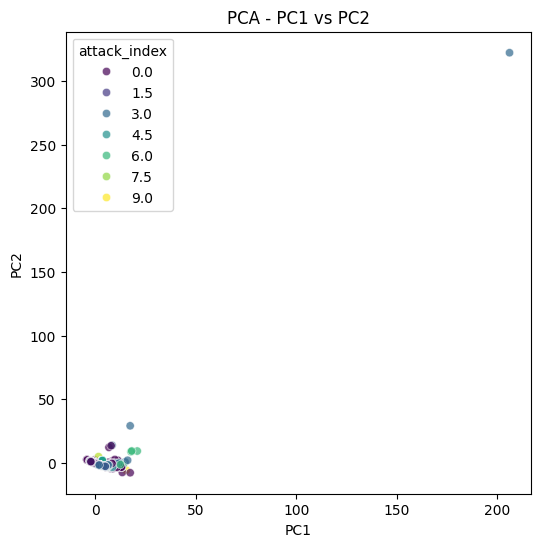

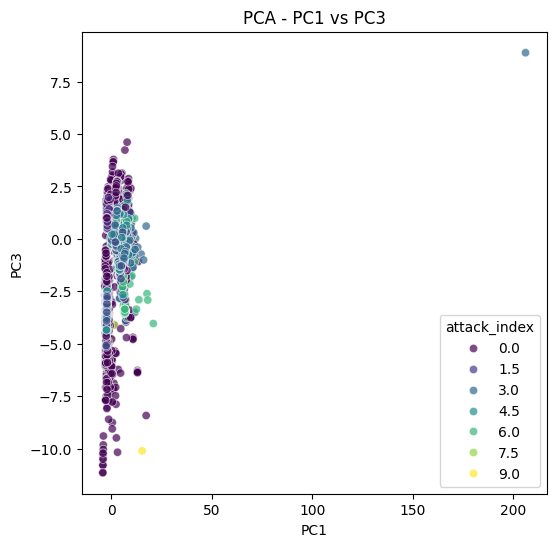

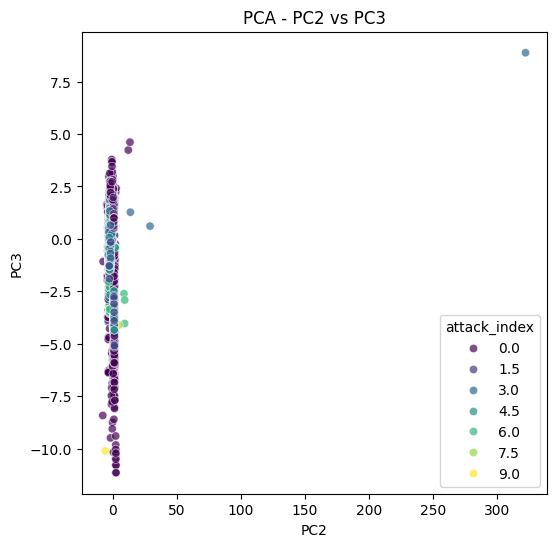

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pca_scatter(pca_result, target: str = TARGET, num_components: int = COMPONENTS):

    # Convert PCA results to Pandas DataFrame for visualization
    pca_pd = pca_result.limit(ROW_LIMIT).toPandas()

    # Extract principal components into separate columns
    pca_columns = [f'PC{i+1}' for i in range(num_components)]
    pca_components = pd.DataFrame(pca_pd['pca_features'].apply(lambda x: x[:num_components]).tolist(), columns=pca_columns, index=pca_pd.index)

    # Combine PCA components with the target variable
    pca_pd = pd.concat([pca_pd, pca_components], axis=1)

    def scatter_plot(pca_pd, x, y):
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=x, y=y, hue=target, data=pca_pd, palette='viridis', alpha=0.7)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f'PCA - {x} vs {y}')
        plt.legend(title=target)
        plt.show()
    
    # Plot foreach pair of principal components
    for i in range(num_components):
        for j in range(i+1, num_components):
            scatter_plot(pca_pd, pca_columns[i], pca_columns[j])

# Plot PCA results
plot_pca_scatter(pca_result)

In [117]:
def significant_features_by_pca(pca_model, features = FEATURES):    
    # Estrai il modello PCA
    pca_stage = pca_model.stages[-1]
    
    # Ottieni le componenti principali
    pca_components = pca_stage.pc.toArray()
    
    # Ottieni la varianza spiegata
    explained_variance = pca_stage.explainedVariance.toArray()
    
    # Determina le features più significative
    significant_features = {}
    for i, ev in enumerate(explained_variance):
        component = pca_components[:, i]
        # Le features significative per questa componente
        feature_contributions = {features[j]: abs(component[j]) for j in range(len(features))}
        # Ordina per contributo in ordine decrescente
        sorted_features = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        significant_features[f'PC{i+1}'] = sorted_features
    
    return significant_features, explained_variance

# Esegui l'analisi PCA e determina le features più significative
significant_features, explained_variance = significant_features_by_pca(pca_model)


In [120]:
print("\nExplained variance for each principal component:")
for i, ev in enumerate(explained_variance):
    print(f"PC{i+1}: {ev:.4f}")

print("\nSum of explained variance:", explained_variance.sum())

print("\nTop 10 features for each principal component:")
for pc, features in significant_features.items():
    print(f"\n{pc}:")
    for feature, contribution in features[:10]:  # Mostra le prime 10 features per ogni componente
        print(f"{feature}: {contribution:.4f}")


Explained variance for each principal component:
PC1: 0.2122
PC2: 0.1614
PC3: 0.0698

Sum of explained variance: 0.44347041308652896

Top 10 features for each principal component:

PC1:
CLIENT_TCP_FLAGS: 0.2544
TCP_WIN_MAX_IN: 0.2489
MIN_TTL: 0.2365
MAX_TTL: 0.2363
SERVER_TCP_FLAGS: 0.2352
OUT_BYTES: 0.2322
LONGEST_FLOW_PKT: 0.2302
MAX_IP_PKT_LEN: 0.2302
TCP_WIN_MAX_OUT: 0.2292
OUT_PKTS: 0.2248

PC2:
NUM_PKTS_512_TO_1024_BYTES: 0.3172
RETRANSMITTED_IN_BYTES: 0.3166
RETRANSMITTED_IN_PKTS: 0.3142
NUM_PKTS_256_TO_512_BYTES: 0.3023
SRC_TO_DST_SECOND_BYTES: 0.2936
DST_TO_SRC_SECOND_BYTES: 0.2827
IN_BYTES: 0.2452
OUT_BYTES: 0.2298
OUT_PKTS: 0.2121
TCP_WIN_MAX_IN: 0.1757

PC3:
PROTOCOL: 0.4775
DNS_QUERY_ID: 0.4409
MIN_IP_PKT_LEN: 0.3442
SHORTEST_FLOW_PKT: 0.3211
DNS_QUERY_TYPE: 0.2699
L4_DST_PORT: 0.2164
DST_TO_SRC_AVG_THROUGHPUT: 0.1542
L7_PROTO: 0.1418
Label: 0.1407
dst_subnet_index: 0.1383


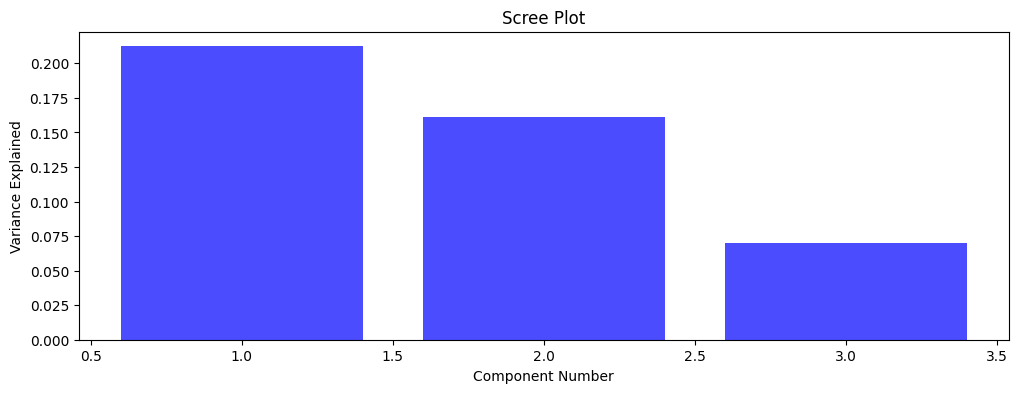

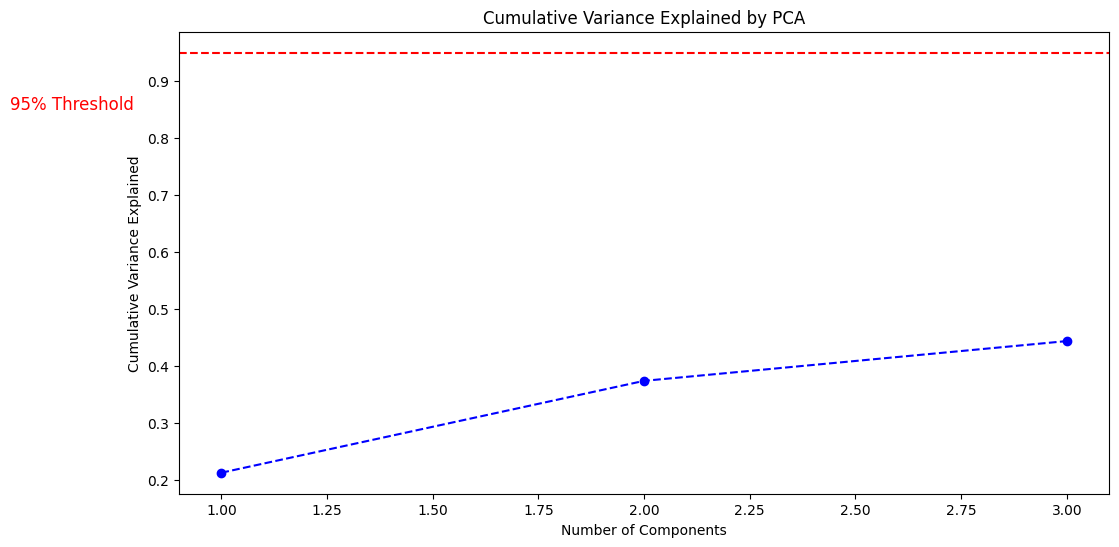

In [132]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scree(explained_variance):
    plt.figure(figsize=(12, 4))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b', align='center')
    plt.xlabel('Component Number')
    plt.ylabel('Variance Explained')
    plt.title('Scree Plot')
    plt.show()

def plot_cumulative_variance(explained_variance):
    cumulative_variance = np.cumsum(explained_variance)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained by PCA')
    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.text(0.5, 0.85, '95% Threshold', color='red', fontsize=12)
    plt.show()

plot_scree(explained_variance)
plot_cumulative_variance(explained_variance)


In [123]:
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd

def PCA_loadings(pca_model, features = FEATURES, k=COMPONENTS):
    
    # Extract PCA loadings
    pca_stage = pca_model.stages[-1]
    loadings = pca_stage.pc.toArray()
    
    # Create a DataFrame for loadings
    loadings_df = pd.DataFrame(loadings, index=features, columns=[f'PC{i+1}' for i in range(k)])
    
    return loadings_df

# Run PCA on the training data
loadings_df = PCA_loadings(pca_model)

# Display PCA loadings
print(loadings_df)


                                  PC1       PC2       PC3
L4_SRC_PORT                 -0.000828 -0.006156 -0.111864
L4_DST_PORT                 -0.062293  0.042244  0.216363
ICMP_TYPE                    0.095437  0.000472  0.030280
ICMP_IPV4_TYPE               0.095436  0.000470  0.030280
DNS_QUERY_ID                -0.078138  0.061088 -0.440920
DNS_QUERY_TYPE              -0.044310  0.035382 -0.269917
DNS_TTL_ANSWER              -0.018535  0.014912 -0.133613
FTP_COMMAND_RET_CODE         0.005570 -0.006749 -0.002560
IN_BYTES                     0.141998  0.245204  0.007758
OUT_BYTES                    0.232223  0.229758 -0.046949
IN_PKTS                      0.039287  0.067360  0.005113
OUT_PKTS                     0.224800  0.212125 -0.021765
FLOW_DURATION_MILLISECONDS   0.160996 -0.097107  0.099914
PROTOCOL                    -0.088991  0.069297 -0.477483
SRC_TO_DST_SECOND_BYTES      0.144048  0.293569  0.024660
DST_TO_SRC_SECOND_BYTES      0.151903  0.282740  0.010722
LONGEST_FLOW_P

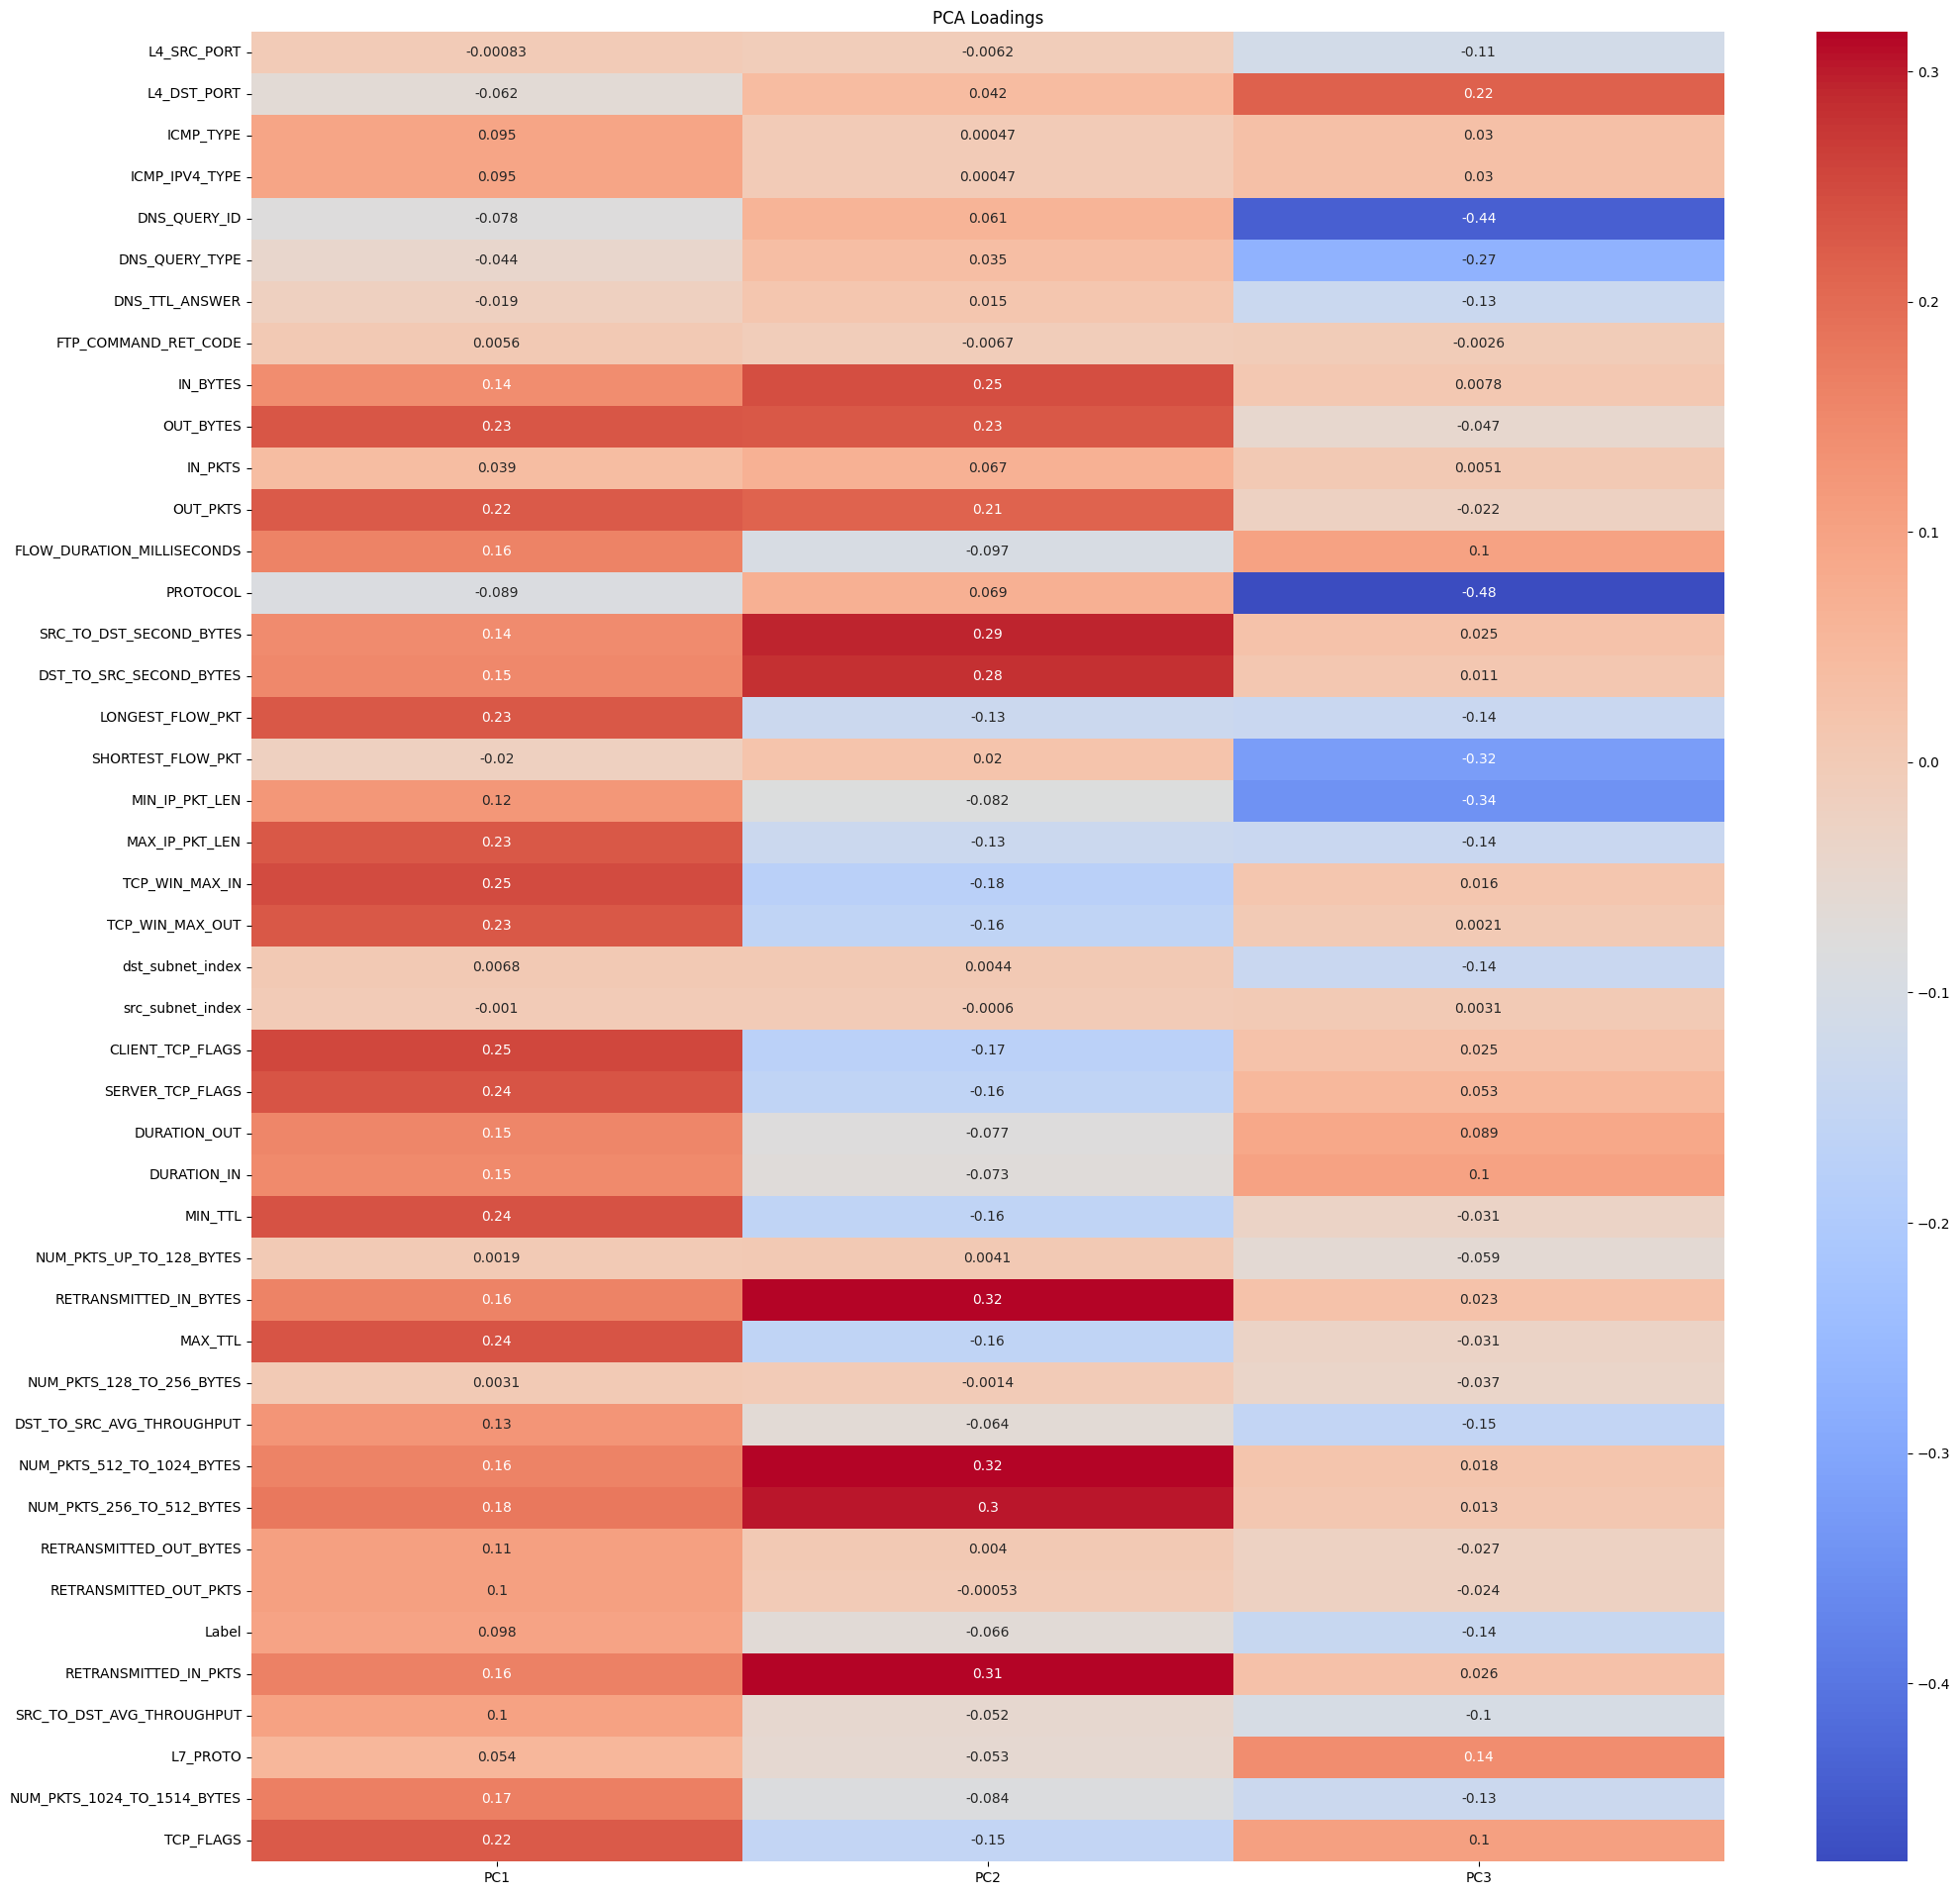

In [124]:
# Graph PCA loadings for each feature
def plot_pca_loadings(loadings_df):
    plt.figure(figsize=(24, 24))
    sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
    plt.title('PCA Loadings')
    plt.show()

plot_pca_loadings(loadings_df)

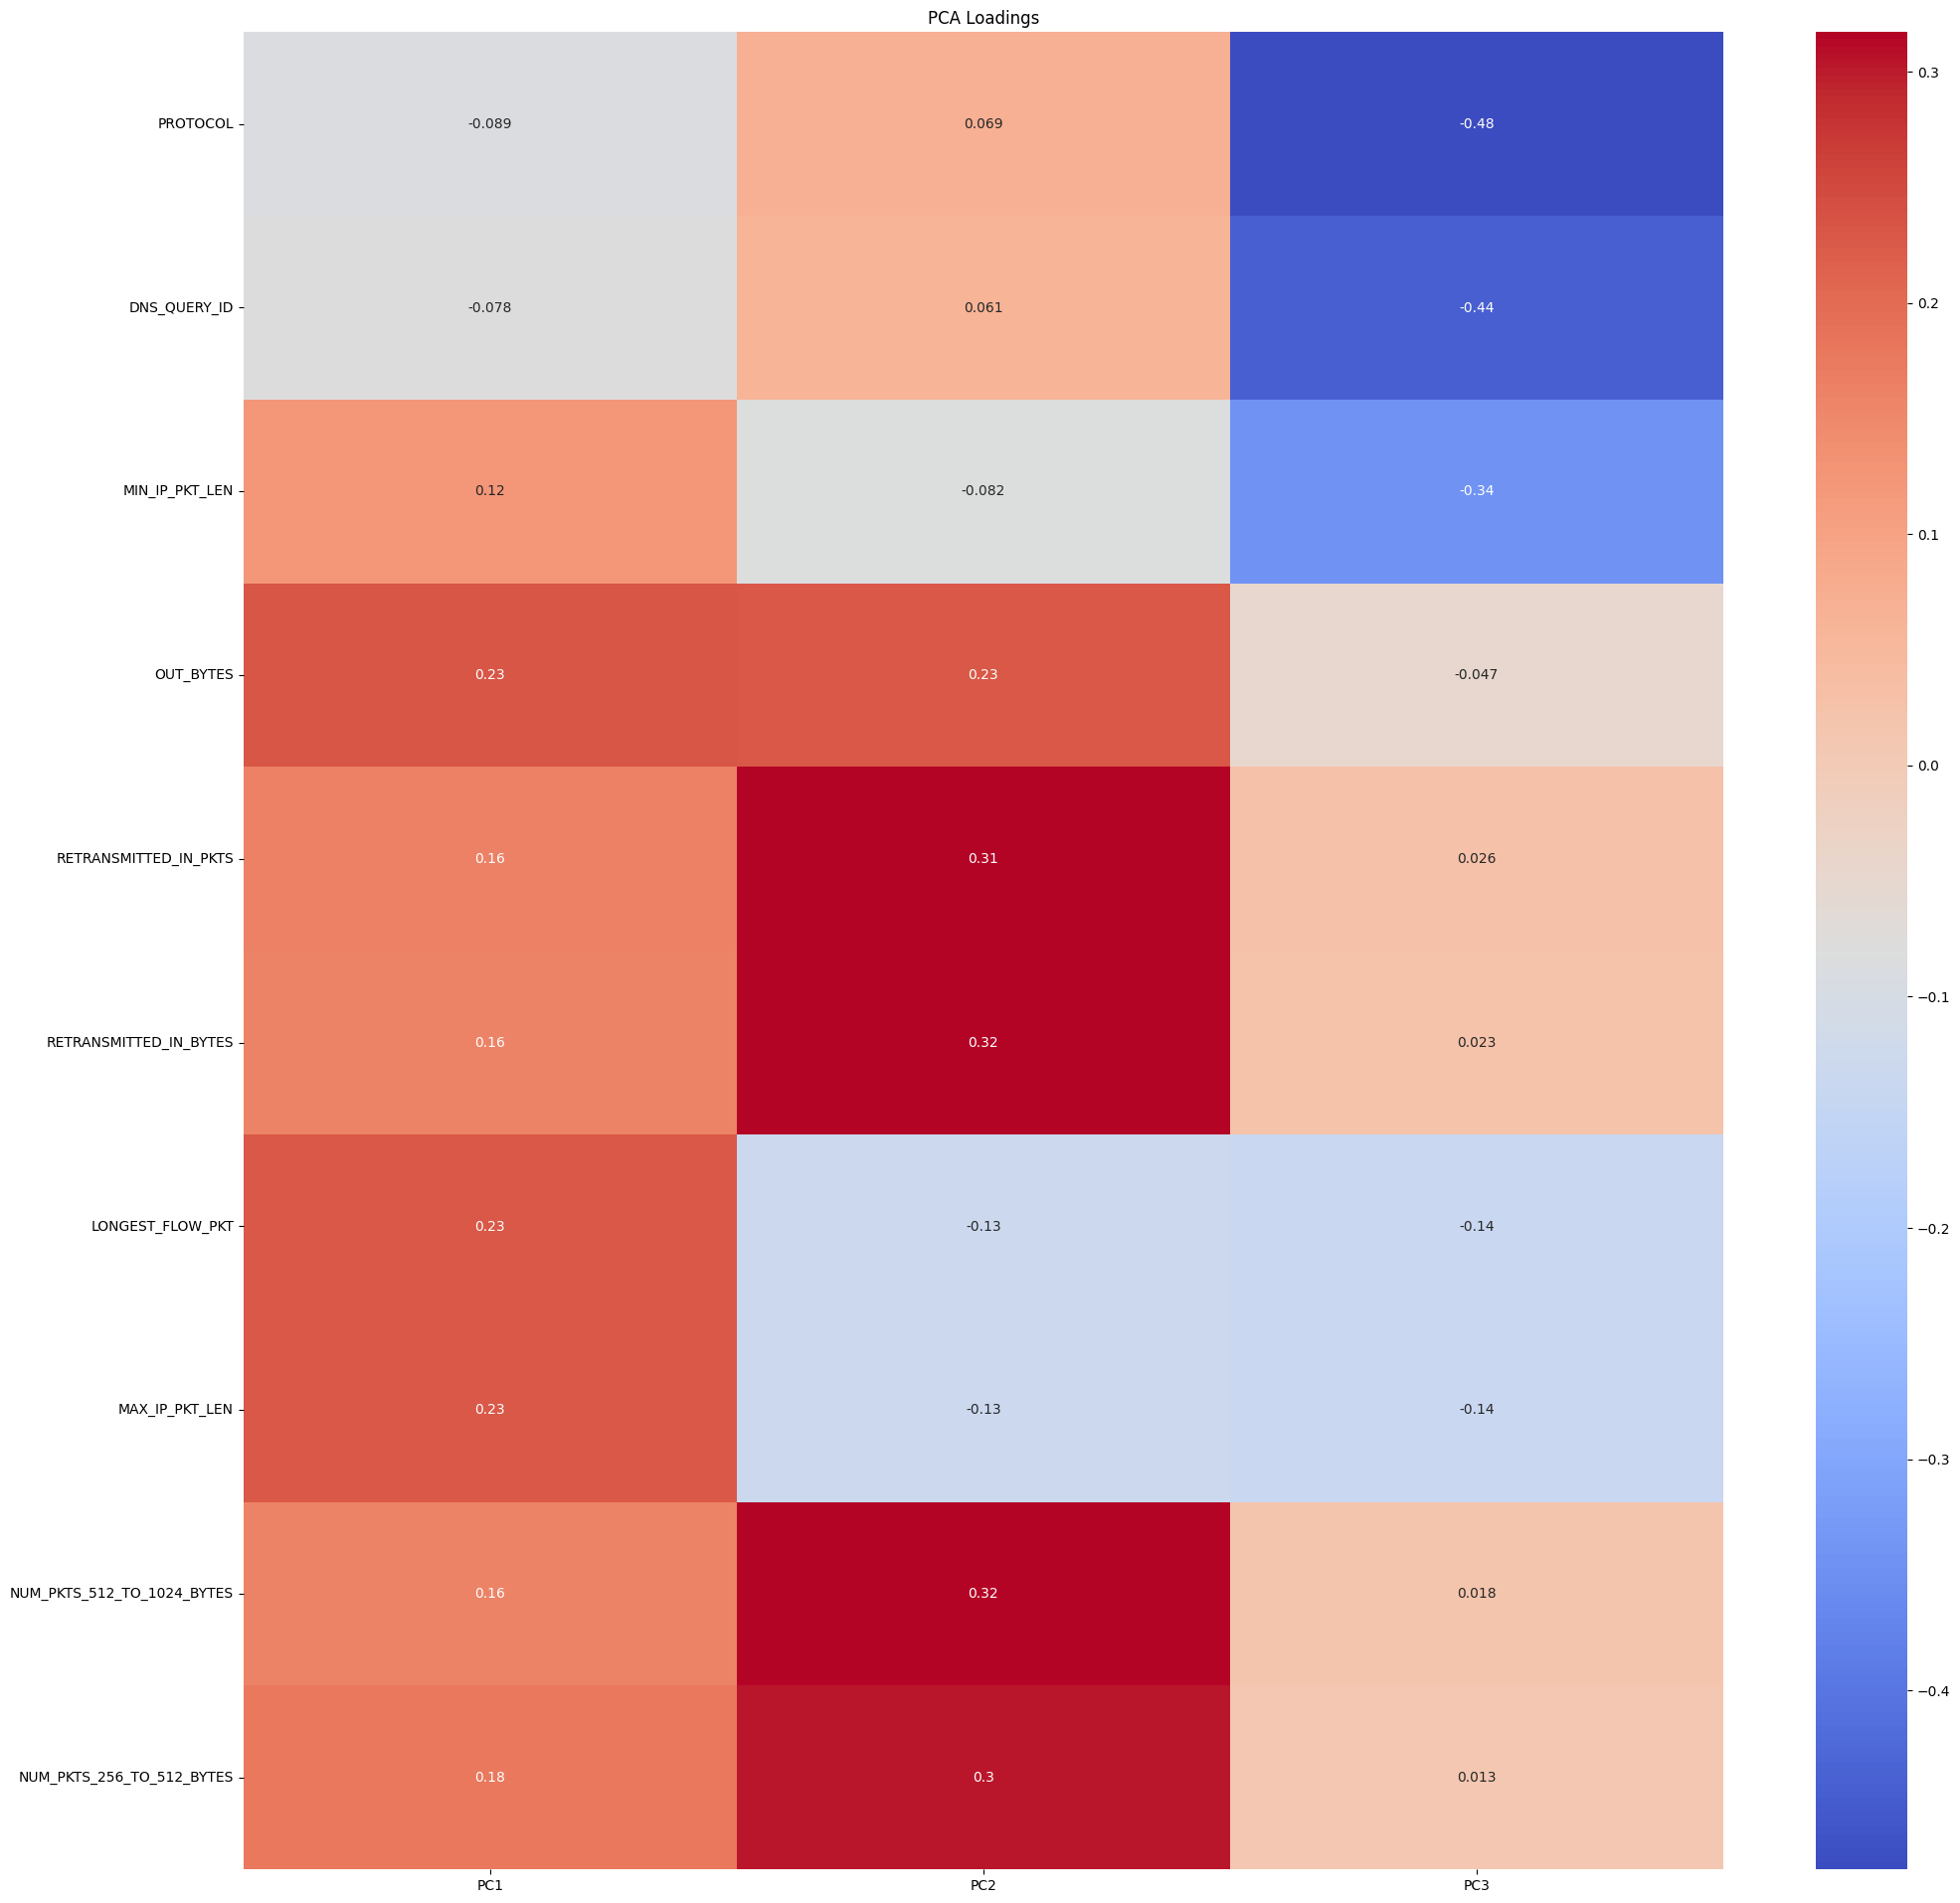

In [125]:
# Plot PCA loadings for the top 10 features
top_features = loadings_df.abs().sum(axis=1).sort_values(ascending=False).head(10).index
top_loadings_df = loadings_df.loc[top_features]
plot_pca_loadings(top_loadings_df)

In [126]:
# Multiple Information (MI) Analysis for the features
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = encoded_train_data.toPandas()

# Select features and target
X = pandas_df[FEATURES]
y = pandas_df[TARGET]

# Calculate mutual information
mi = mutual_info_classif(X, y)

# Display Mutual Information scores
feature_mi_scores = [(feature, score) for feature, score in zip(features, mi)]
for feature, score in feature_mi_scores:
    print(f"Feature: {feature}, MI Score: {score}")

Feature: ('PROTOCOL', 0.4774834396784462), MI Score: 0.42492245340508905
Feature: ('DNS_QUERY_ID', 0.4409199600861238), MI Score: 0.863958231901149
Feature: ('MIN_IP_PKT_LEN', 0.344151581937391), MI Score: 0.029570452285741844
Feature: ('SHORTEST_FLOW_PKT', 0.3211105628660165), MI Score: 0.021886849386413942
Feature: ('DNS_QUERY_TYPE', 0.2699174148281373), MI Score: 0.1724764798746361
Feature: ('L4_DST_PORT', 0.2163628895967451), MI Score: 0.19415169613671202
Feature: ('DST_TO_SRC_AVG_THROUGHPUT', 0.15421330126660346), MI Score: 0.08489297116625627
Feature: ('L7_PROTO', 0.14178441629039062), MI Score: 0.0059063449624652264
Feature: ('Label', 0.14066765475052878), MI Score: 1.192430311133364
Feature: ('dst_subnet_index', 0.13831487784007362), MI Score: 1.0212203957682888
Feature: ('LONGEST_FLOW_PKT', 0.13742375243489344), MI Score: 0.4329243557319913
Feature: ('MAX_IP_PKT_LEN', 0.1374237524348934), MI Score: 0.4903254607162335
Feature: ('DNS_TTL_ANSWER', 0.13361255503277494), MI Score: 

The PCA revealed that the first two principal components explain approximately 69.17% of the variance in the dataset, with significant contributions from features such as FLOW_DURATION_MILLISECONDS, TCP_WIN_MAX_OUT, and L4_DST_PORT. The heatmap provided a visual representation of feature correlations, identifying relationships that guided feature selection. The MI analysis highlighted MAX_IP_PKT_LEN and LONGEST_FLOW_PKT as the most informative features for predicting the target variable, attack_index, indicating their potential importance in the classification tasks.

#### Feature Scalling
Feature scaling can play a crucial role in optimizing the performance of machine learning models, especially those sensitive to the scale of input data.
Applying feature scaling to the right variables essential for improving model accuracy and efficiency. It ensures that each feature contributes equally to the decision-making process, preventing models from misinterpreting the data due to arbitrary feature scales. This leads to better, more reliable predictions in multiclass classification tasks.

##### Numerical Variables with Different Scales: